In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

from sklearn import model_selection
import numpy as np

from sklearn.linear_model import LogisticRegression as LogReg

In [2]:
#Для подавления предупреждений о недостаточной сходимости можно использовать:
import warnings

In [3]:
def log_loss(pred, y): return -np.sum(y*np.log2(pred)+(1-y)*np.log2(1-pred))/len(y)

In [4]:
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)
def get_error(pred, y):
    return np.sum((pred != y).astype(int)) / len(y)

Реализовать адаптивный бустинг использующий Логистическую Регрессию и меру ошибок LogLoss. Сравнить с точностью адаптивного бустинга на деревьях решений. Изменили clf, добавили пропуск ошибки.

In [5]:
def adaboost(X, y, N):

    # Размер выборки
    n_objects = len(X)

    # Запишем количество классов в переменную
    n_classes = len(np.unique((y)))

    # Начальные веса деревьев
    w = np.ones(n_objects) / n_objects

    # Деревья с весами будем записывать в список
    models = []

    for n in range(N):
        # Зададим дерево и обучим его
        clf=LogReg()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            clf.fit(X, y, w)
            
        predictions = clf.predict(X)
        predictions_proba = clf.predict_proba(X)[:, 1]
        
        e = log_loss(predictions_proba, y)
        
        # отбросим дерево, если его ошибка больше 0.5
        # Запишем условие в общем виде (применимо к небинарным классификаторам)
        if e >= 1: 
            break

        # Вычислим вес для дерева
        alpha = 0.5 * np.log((1 - e) / e)

        # Найдем индексы правильно классифицированных элементов
        match = predictions == y

        # Увеличим веса для неправильно классифицированных элементов
        w[np.logical_not(match)] *= np.exp(alpha)
        w[match] *= np.exp(-alpha)

        # Нормализуем веса
        w /= w.sum()

        # Добавим дерево с весом в список
        models.append((alpha, clf))
    
    return models

In [6]:
N = 50

models = adaboost(X_train, y_train, N)

In [7]:
def predict(X, models):
    
    n_objects = len(X)
    
    # вначале обозначим предсказание нулевым массивом
    y_pred = np.zeros((n_objects,))
    
    for alpha, clf in models:
        score = clf.decision_function(X)
        # Для каждого предсказания будем прибавлять alpha к
        # элементу с индексом предсказанного класса
        y_pred += alpha*score
    
    return (y_pred>0).astype(int)

print(f'Точность алгоритма на обучающей выборке: {(1 - get_error(predict(X_train, models), y_train)) * 100:.3f}')

Точность алгоритма на обучающей выборке: 93.897


In [8]:
print(f'Точность алгоритма на тестовой выборке: {(1 - get_error(predict(X_test, models), y_test)) * 100:.3f}')

Точность алгоритма на тестовой выборке: 95.105


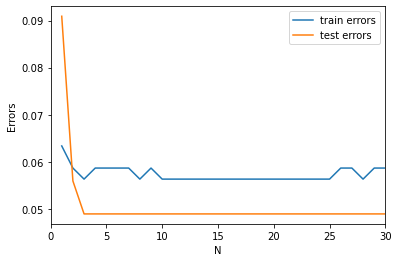

In [9]:
train_errors = []
test_errors = []

for n in range(1, 31):
    mods = adaboost(X_train, y_train, n)
    train_errors.append(get_error(predict(X_train, mods), y_train))
    test_errors.append(get_error(predict(X_test, mods), y_test))
x = list(range(1, 31))

plt.xlim(0, 30)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N')
plt.ylabel('Errors')
plt.legend(loc='upper right')

Примеим снижение размерности

In [10]:
# Для начала отмасштабируем выборку
X = X_train.astype(float)
mean=np.apply_along_axis(np.mean, 0, X)
std=np.apply_along_axis(np.std, 0, X)
X_normed_trained=(X-mean[np.newaxis, :])/std[np.newaxis, :]

In [11]:
# Найдем собственные векторы и собственные значения
 
covariance_matrix = X_normed_trained.T.dot(X_normed_trained)

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack((eig_pairs[0][1].reshape(30,1), eig_pairs[1][1].reshape(30,1)))

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[ 0.22649312 -0.22680836]
 [ 0.10068454 -0.05566998]
 [ 0.23451214 -0.20798046]
 [ 0.2284274  -0.22166813]
 [ 0.13561746  0.17476848]
 [ 0.24102894  0.1526159 ]
 [ 0.25944276  0.08054655]
 [ 0.26528604 -0.03169332]
 [ 0.12431308  0.19535592]
 [ 0.05599797  0.37103908]
 [ 0.20319456 -0.09023493]
 [ 0.00852603  0.09843398]
 [ 0.20882693 -0.07398092]
 [ 0.20761864 -0.14050035]
 [ 0.00721071  0.19967681]
 [ 0.15988601  0.25691463]
 [ 0.1426267   0.22687291]
 [ 0.17351096  0.15913648]
 [ 0.02315838  0.17312716]
 [ 0.09703006  0.29828776]
 [ 0.23432379 -0.21564922]
 [ 0.10128285 -0.0529976 ]
 [ 0.24234544 -0.19574069]
 [ 0.23118421 -0.21193692]
 [ 0.12464073  0.14860162]
 [ 0.21253478  0.13305404]
 [ 0.22972609  0.10744141]
 [ 0.25317367 -0.0109097 ]
 [ 0.11152278  0.11775925]
 [ 0.13105993  0.27088421]]


In [12]:
new_X_train=X_normed_trained.dot(W)

In [13]:
X_normed_test=(X_test-mean[np.newaxis, :])/std[np.newaxis, :]
new_X_test=X_normed_test.dot(W)

In [14]:
N = 50

models_min = adaboost(new_X_train, y_train, N)

In [15]:
print(f'Точность алгоритма на обучающей выборке: {(1 - get_error(predict(new_X_train, models_min), y_train)) * 100:.3f}')

Точность алгоритма на обучающей выборке: 92.958


In [16]:
print(f'Точность алгоритма на тестовой выборке: {(1 - get_error(predict(new_X_test, models_min), y_test)) * 100:.3f}')

Точность алгоритма на тестовой выборке: 93.706


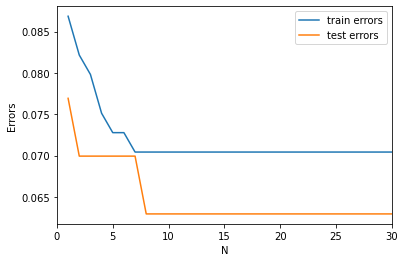

In [17]:
train_errors = []
test_errors = []

for n in range(1, 31):
    mods = adaboost(new_X_train, y_train, n)
    train_errors.append(get_error(predict(new_X_train, mods), y_train))
    test_errors.append(get_error(predict(new_X_test, mods), y_test))
x = list(range(1, 31))

plt.xlim(0, 30)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N')
plt.ylabel('Errors')
plt.legend(loc='upper right')

Из полученных данных видно, что для бустинга снижение размерности с двуме компонентами точность снизило, но результат остался достаточно высоким.